# Objective 1

Setting up the MNIST Dataset and creating a CNN in PyTorch

## Imports, Hyperparameters, and Loading Data

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

DATA_PATH = "./data"
MODEL_PATH = "./models"

In [7]:
# Hyperparameters
EPOCHS = 6
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [8]:
# a transform to apply to data (convert to Tensor, then normalize w/ MNIST's mean & sd)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

In [9]:
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

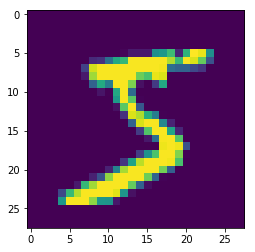

In [10]:
plt.imshow(train_dataset.train_data[0])
plt.show()

To load the model:

In [13]:
model = ConvNet()
model.load_state_dict(torch.load(MODEL_PATH + 'conv_net_1(conv)_2_model.ckpt'))

## Training a Good Convolutional Neural Network 

The ConvNet I chose has the following layers:
   * Layer 1 (Convolutional): 32 5x5 convolutional filters --> ReLU nonlinearity --> 2x2 Maxpool
   * Dropout 
   * Layer 2 (Linear): 14x14x32 --> 1000 Fully Connected layer
   * Layer 3 (Output): 1000 --> 10 Fully Connected Layer 
   * SoftMax included in nn.CrossEntropyLoss()

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
#       self.layer2 = nn.Sequential(
#           nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2, stride=2)
#           )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(14 * 14 * 32, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
#        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [83]:
model = ConvNet()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [68]:
# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        # Run forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Now backpropogate and apply Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted==labels).sum().item()
        acc_list.append(correct / total)
        
        if (i+1) % 100 == 0:
             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [100/600], Loss: 0.2542, Accuracy: 89.00%
Epoch [1/6], Step [200/600], Loss: 0.1430, Accuracy: 93.00%
Epoch [1/6], Step [300/600], Loss: 0.2477, Accuracy: 92.00%
Epoch [1/6], Step [400/600], Loss: 0.2554, Accuracy: 93.00%
Epoch [1/6], Step [500/600], Loss: 0.1063, Accuracy: 97.00%
Epoch [1/6], Step [600/600], Loss: 0.1122, Accuracy: 96.00%
Epoch [2/6], Step [100/600], Loss: 0.1875, Accuracy: 94.00%
Epoch [2/6], Step [200/600], Loss: 0.0763, Accuracy: 98.00%
Epoch [2/6], Step [300/600], Loss: 0.1185, Accuracy: 96.00%
Epoch [2/6], Step [400/600], Loss: 0.1038, Accuracy: 96.00%
Epoch [2/6], Step [500/600], Loss: 0.0706, Accuracy: 97.00%
Epoch [2/6], Step [600/600], Loss: 0.1575, Accuracy: 96.00%
Epoch [3/6], Step [100/600], Loss: 0.1800, Accuracy: 92.00%
Epoch [3/6], Step [200/600], Loss: 0.0743, Accuracy: 98.00%
Epoch [3/6], Step [300/600], Loss: 0.1216, Accuracy: 96.00%
Epoch [3/6], Step [400/600], Loss: 0.0305, Accuracy: 99.00%
Epoch [3/6], Step [500/600], Loss: 0.022

## Testing the accuracy

In [151]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted==labels).sum().item()
        total += labels.size(0)
    
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    
# Save the model and plot
#torch.save(model.state_dict(), MODEL_PATH + 'conv_net_1(conv)_2_model.ckpt')

Test Accuracy of the model on the 10000 test images: 98.35000000000001 %


Now we find the variance of the output of our model

In [35]:
model.eval()

results = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        results.append(predicted)
    
results = torch.cat(results) 
variance = (results.float().std()/9)**2
print(variance)

tensor(0.1039)


In [36]:
# Compare to the pre-sample variance
(test_dataset.test_labels.float().std()/9)**2

tensor(0.1035)

## Plot the accuracy

In [75]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, export_png
from bokeh.models import LinearAxis, Range1d
import numpy as np

output_notebook() # for printing in jupyter

p = figure(y_axis_label='Loss', width=850, y_range=(0,1), title='PyTorch ConvNet Results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0,end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(acc_list)), acc_list, color='red')
export_png(p, filename='ConvNetAccLoss.png')

Loading BokehJS ...

'/Users/tylerzhu/Desktop/tyleryzhu/pallas-starter-project/ConvNetAccLoss.png'

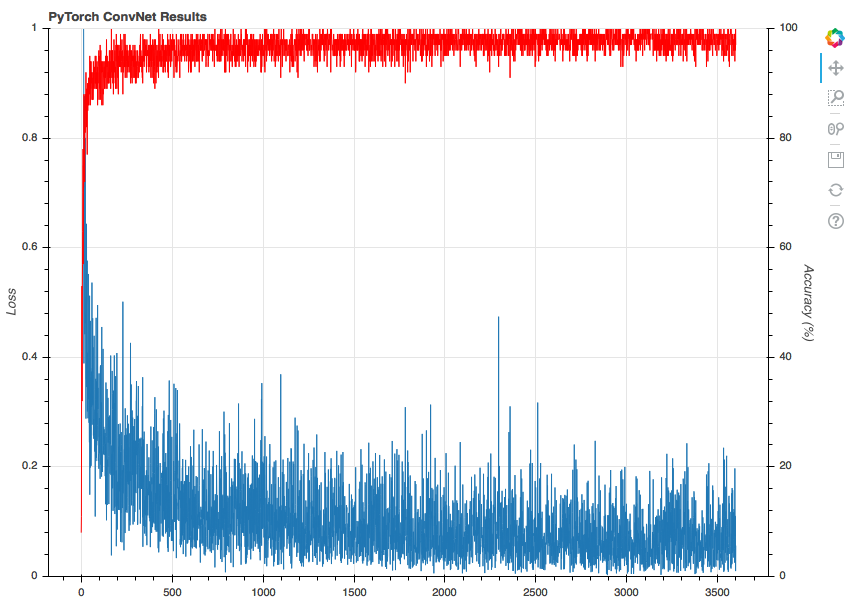

In [81]:
from IPython.display import Image
Image('./ConvNetAccLoss.png')

## Creating a function for measuring variance 

In [137]:
def varModel(model, loader):
    ''' Returns the variance of model over samples as a PyTorch tensor.
    
        Inputs:
        model: a PyTorch Neural Network.
        samples: a PyTorch Data Loader of the samples to test (usually test_loader)'''
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            results.append(predicted)

    results = torch.cat(results).float() 
    std = results.std()/(results.max()-results.min())
    return std**2 

In [138]:
varModel(model, test_loader).item()

0.10240806639194489

## Creating samples with noise

One big problem here is that I can't directly add noise to the tensor, since negatives values get wrapped modulo 256. I can't figure out a good way to do this, so I had two approaches:

* noisy, which essentially avoids adding the noise if it causes a wraparound (extremely slow; unusable)
* badNoisy, which doesn't care but at least is far faster

I made these functions take tensors as input. My goal was to use them as a transform using transforms.Lambda. Some testing shows that this does do something, but I'm not convinced it's exactly what I want. 

In [57]:
def addNoise(inp, sigma, clamp = True): 
    ''' Adds Gaussian noise N(0, sigma) to a tensor inp.
        Clamps values to [0, 255]
        Returns a FloatTensor with noise added.'''
    inp = inp.type(torch.FloatTensor)
    shape = inp.shape 
    noise = torch.tensor(np.random.normal(0, sigma, size = shape)).type(torch.FloatTensor)
    return torch.clamp(noise+inp, 0, 255) if clamp else noise+inp #to clamp or not to clamp? 

In [69]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans, download=False)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [59]:
t = test_dataset.test_data[0]

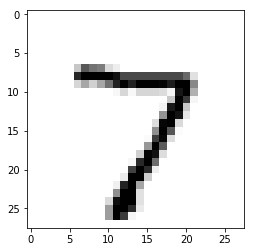

In [60]:
plt.imshow(t, cmap='Greys')

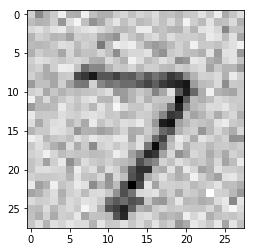

In [67]:
n = addNoise(t,50, False)
plt.imshow(n.type(torch.IntTensor), cmap='Greys')

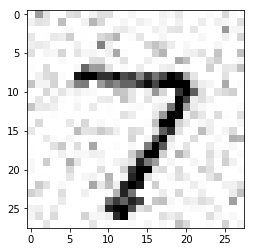

In [68]:
plt.imshow(torch.clamp(n.type(torch.IntTensor), 0, 255), cmap='Greys')

In [126]:
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans, download=False)
noisy_test_dataset = test_dataset
for i in range(len(noisy_test_dataset.test_data)):
    noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], 50)

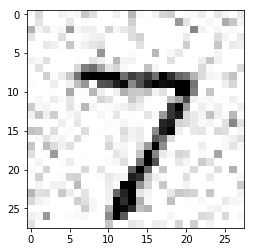

In [128]:
plt.imshow(test_dataset.test_data[0], cmap = 'Greys')

As you can see, I essentially created a new transformed test dataset for every sigma that I wanted to try. I return a list of variances corresponding to the input sigmas. The only problem are the results (see below)

In [142]:
def varianceTest(model, sigmas, epochs = 1):
    ''' Returns model(Y) over X+e where e = N(0, sigma). sigmas is a list of sigmas'''
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    outputVariance = []
    for sigma in sigmas:
        print("Computing variance of f(Y) where noise has sigma =", sigma)
        tot = 0
        for epoch in range(epochs): 
            print("Epoch {} of {}".format(epoch+1, epochs))
            noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans, \
                                                            download=False)
            for i in range(len(noisy_test_dataset.test_data)):
                noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], sigma)
            test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
            tot += varModel(model, test_loader).item()
        outputVariance.append(tot/epochs)
        print("Variance with noise std {} is {}".format(sigma, outputVariance[-1]))
    return outputVariance

In [140]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))])
noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans, \
                                                        download=False)
for i in range(len(noisy_test_dataset.test_data)):
    noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], 50) 
test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
varModel(model, test_loader).item()

0.1027376651763916

In [145]:
sigs = np.linspace(0, 50, 6) 

In [146]:
result = varianceTest(model, sigs, epochs=4)

Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 4
Epoch 2 of 4
Epoch 3 of 4
Epoch 4 of 4
Variance with noise std 0.0 is 0.10386093705892563
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 4
Epoch 2 of 4
Epoch 3 of 4
Epoch 4 of 4
Variance with noise std 10.0 is 0.10398676432669163
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 4
Epoch 2 of 4
Epoch 3 of 4
Epoch 4 of 4
Variance with noise std 20.0 is 0.10384941287338734
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 4
Epoch 2 of 4
Epoch 3 of 4
Epoch 4 of 4
Variance with noise std 30.0 is 0.1036980003118515
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 4
Epoch 2 of 4
Epoch 3 of 4
Epoch 4 of 4
Variance with noise std 40.0 is 0.1034293994307518
Computing variance of f(Y) where noise has sigma = 50.0
Epoch 1 of 4
Epoch 2 of 4
Epoch 3 of 4
Epoch 4 of 4
Variance with noise std 50.0 is 0.10263211093842983


In [147]:
result

[0.10386093705892563,
 0.10398676432669163,
 0.10384941287338734,
 0.1036980003118515,
 0.1034293994307518,
 0.10263211093842983]

In [148]:
def display(sigmas, results):
    plt.plot(sigmas, results)
    plt.title('Sigma vs. Variance')
    plt.show()

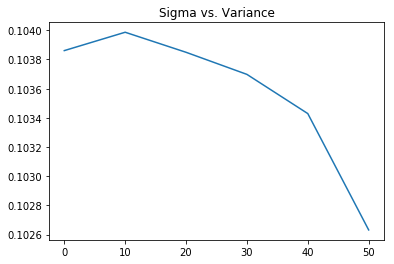

In [149]:
display(sigs, result)